In [1]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
import scipy

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [3]:
# freeze
for layer in pre_trained_model.layers:
    layer.trainable = False

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 6, 768)


In [5]:
from utils.dataset import get_num_classes
num_classes = get_num_classes()
num_classes

6

In [6]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(num_classes, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001), metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

c:\Users\tmdfl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 conv2d_28 (Conv2D)             (None, 13, 13, 96)   55296       ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 13, 13, 96)  288         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 13, 13, 96)   0           ['batch_normalization_28[0][0]'] 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 6, 6, 384)    995328      ['mixed2[0][0]']                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 6, 6, 96)     82944       ['activation_28[0][0]']          
          

In [7]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = 'process_result'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(128, 128),  
    batch_size=5,
    class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=5,
    class_mode='categorical')

Found 228 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=40,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

C:\Users\tmdfl\AppData\Local\Temp\ipykernel_19256\3338194908.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
40/40 - 17s - loss: 1.1078 - acc: 0.6263 - val_loss: 0.3442 - val_acc: 0.8800 - 17s/epoch - 420ms/step
Epoch 2/10
40/40 - 16s - loss: 0.3587 - acc: 0.8788 - val_loss: 0.1325 - val_acc: 0.9600 - 16s/epoch - 390ms/step
Epoch 3/10
40/40 - 13s - loss: 0.1769 - acc: 0.9343 - val_loss: 0.1691 - val_acc: 0.9600 - 13s/epoch - 320ms/step
Epoch 4/10
40/40 - 13s - loss: 0.0928 - acc: 0.9798 - val_loss: 0.2198 - val_acc: 0.9200 - 13s/epoch - 326ms/step
Epoch 5/10
40/40 - 18s - loss: 0.1441 - acc: 0.9495 - val_loss: 0.6277 - val_acc: 0.9000 - 18s/epoch - 458ms/step
Epoch 6/10
40/40 - 15s - loss: 0.1258 - acc: 0.9545 - val_loss: 0.2710 - val_acc: 0.9400 - 15s/epoch - 383ms/step
Epoch 7/10
40/40 - 11s - loss: 0.0460 - acc: 0.9798 - val_loss: 0.3914 - val_acc: 0.8800 - 11s/epoch - 273ms/step
Epoch 8/10
40/40 - 12s - loss: 0.0381 - acc: 0.9848 - val_loss: 0.2111 - val_acc: 0.9200 - 12s/epoch - 295ms/step
Epoch 9/10
40/40 - 11s - loss: 0.0722 - acc: 0.9747 - val_loss: 0.4464 - val_acc: 0.8600

In [9]:
def to_label(output):
    indicies = train_generator.class_indices
    for key, value in indicies.items():
        if value == np.argmax(output):
            return key

(128, 128, 3)
naganohara_yoimiya


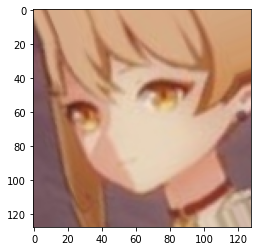

In [10]:
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

data = train_generator.next()
image = data[0][0]
print(image.shape)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print(to_label(data[1][0]))

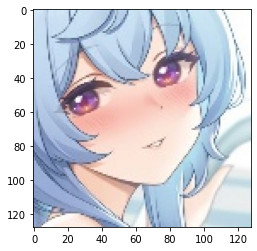

(128, 128, 3) float32
1/1 [==============================] - 0s 89ms/step
ganyu


In [66]:
rand_path = "process_result/valid"
rand_path = os.path.join(rand_path, random.choice(os.listdir(rand_path)))
rand_path = os.path.join(rand_path, random.choice(os.listdir(rand_path)))

image = cv2.imread(rand_path)
image = image[:,:,::-1]
image = image.astype(np.float32) / 255
plt.imshow(image)
plt.show()
print(image.shape, image.dtype)
input = np.expand_dims(image, 0)
output = model.predict(input)
print(to_label(output))